# Model creation stage II (4x8)

In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tools import common_functions as cf
from tools import regression as reg
from tools import plotting_functions as pf

from tools import sensor_gui as sg

# Folder prefix with all the taxel data
TAXEL_DATA_FOLDER = f"table_calibration/taxel"


# Parameters
SENSOR_LAG = 80 # ms
ARRAY_SIZE = 32

# Automated
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

In [3]:
taxels_data = []

for i in range(ARRAY_SIZE):
  
  # Load the data
  taxel_data = cf.prepare_data_for_fitting(f"{TAXEL_DATA_FOLDER}{i}", ARRAY_SIZE, SENSOR_LAG, rotation=90 + 1.82, faulty=False, cut_in_half=True)
  taxels_data.append(taxel_data)

Preparing data for fitting: table_calibration/taxel0
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:314: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel1
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:314: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel2
False True


In [ ]:
# Load models from stage I
import os
import dill
    
save_path = os.path.join(os.getcwd(), '..', 'models', "4x8")
models = []
    
for i in range(ARRAY_SIZE):

    with open(os.path.join(save_path, f"taxel{i}"), 'rb') as f:
        model = dill.load(f)
        models.append(model)

with open(os.path.join(save_path, f"stageI"), 'rb') as f:
    stage_I_model = dill.load(f)        

# STAGE IIa

Linear model for crosstalk

In [5]:
# Represents the neighbours of every taxel (including itself)
neighbour_elements = []

def get_neighbors(x, y):
    neighbors = []
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            neighbors.append((i, j))
    return neighbors

for i in range(8):
  for j in range(4):
    
    center_value = i * 4 + j
    
    neighbors = get_neighbors(i, j)
    neighbors_values = [n[0] * 4 + n[1] for n in neighbors]
    real_values = []
    
    for coord in neighbors:
      if coord[0] >= 0 and coord[1] >= 0 and coord[0] <= 7 and coord[1] <= 3:
        real_values.append(coord[0] * 4 + coord[1])
 
    neighbour_elements.append(real_values)

print(neighbour_elements)

[[0, 1, 4, 5], [0, 1, 2, 4, 5, 6], [1, 2, 3, 5, 6, 7], [2, 3, 6, 7], [0, 1, 4, 5, 8, 9], [0, 1, 2, 4, 5, 6, 8, 9, 10], [1, 2, 3, 5, 6, 7, 9, 10, 11], [2, 3, 6, 7, 10, 11], [4, 5, 8, 9, 12, 13], [4, 5, 6, 8, 9, 10, 12, 13, 14], [5, 6, 7, 9, 10, 11, 13, 14, 15], [6, 7, 10, 11, 14, 15], [8, 9, 12, 13, 16, 17], [8, 9, 10, 12, 13, 14, 16, 17, 18], [9, 10, 11, 13, 14, 15, 17, 18, 19], [10, 11, 14, 15, 18, 19], [12, 13, 16, 17, 20, 21], [12, 13, 14, 16, 17, 18, 20, 21, 22], [13, 14, 15, 17, 18, 19, 21, 22, 23], [14, 15, 18, 19, 22, 23], [16, 17, 20, 21, 24, 25], [16, 17, 18, 20, 21, 22, 24, 25, 26], [17, 18, 19, 21, 22, 23, 25, 26, 27], [18, 19, 22, 23, 26, 27], [20, 21, 24, 25, 28, 29], [20, 21, 22, 24, 25, 26, 28, 29, 30], [21, 22, 23, 25, 26, 27, 29, 30, 31], [22, 23, 26, 27, 30, 31], [24, 25, 28, 29], [24, 25, 26, 28, 29, 30], [25, 26, 27, 29, 30, 31], [26, 27, 30, 31]]


In [6]:
print("Prepping...")

all_forces = []
for i in range(ARRAY_SIZE):
  all_forces.append(stage_I_model.predict(taxels_data[i][1000:75000]))

Prepping...


# Linear

In [7]:
# Now we calculate the (non-zero) K_{i.j}'s as a 96x96 matrix
# K_{i,j}: influence of taxel i activation on taxel j (= the neighbour)
coefficients = np.zeros((32 * 3, 32 * 3))
bias = np.zeros((32 * 3))

print("Calculating K_{i,j}...")

cmodel = None

for i in range(ARRAY_SIZE):
  
  neighbours = neighbour_elements[i]
  
  for neighbour in neighbours:
    
    print(f"Creating K_{i, neighbour}...")

    X = all_forces[neighbour][neighbour]
    Y = all_forces[neighbour][i] 
    
    crosstalk_model = reg.create_regression_pipeline_and_fit(X, Y, debug=True, degree=1)[0]
    
    if neighbour == 1 and i == 0:
      cmodel = crosstalk_model
    
    coefficients[i * 3 : (i + 1) * 3, neighbour * 3 : (neighbour + 1) *  3] = crosstalk_model.steps[1][1].coef_[:, 1:]
    bias[i * 3 : (i + 1) * 3] = crosstalk_model.steps[1][1].coef_[:, 0]

Calculating K_{i,j}...
Creating K_(0, 0)...
Score:  1.0
MSE:  1.975862559337783e-30
Creating K_(0, 1)...
Score:  0.9286725973236384
MSE:  0.0017326755758876485
Creating K_(0, 4)...
Score:  0.6998456277284192
MSE:  0.006542471224301274
Creating K_(0, 5)...
Score:  0.768776247849758
MSE:  0.0007900513499662278
Creating K_(1, 0)...
Score:  0.7409626710960158
MSE:  0.033876329943480686
Creating K_(1, 1)...
Score:  1.0
MSE:  2.212391466502983e-30
Creating K_(1, 2)...
Score:  0.8643922271657724
MSE:  0.0662769102647586
Creating K_(1, 4)...
Score:  0.6370892726500815
MSE:  0.0019092402530951084
Creating K_(1, 5)...
Score:  0.7789835173887046
MSE:  0.005263929517814004
Creating K_(1, 6)...
Score:  0.8496532869585516
MSE:  0.00041440997871714826
Creating K_(2, 1)...
Score:  0.8684636905831348
MSE:  0.0017469044983830463
Creating K_(2, 2)...
Score:  1.0
MSE:  2.7431999332621047e-30
Creating K_(2, 3)...
Score:  0.8970546598705558
MSE:  0.0017766142300255888
Creating K_(2, 5)...
Score:  0.52915540

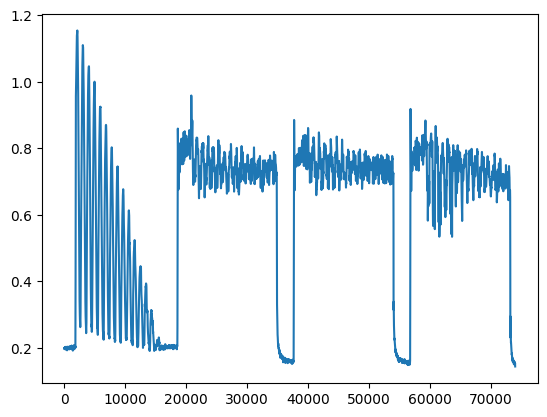

In [8]:
y_pred = cmodel.predict(all_forces[1][1])
plt.plot(y_pred[:,2])

In [9]:
M = np.linalg.inv(coefficients)

In [10]:
with np.printoptions(threshold=np.inf):
    print(coefficients)

[[ 1.00000000e+00 -4.72495307e-16 -2.22044605e-16  2.71448321e-02
  -2.99136816e-02 -1.51010141e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.11969052e-02  5.48615333e-02 -2.45367848e-02  9.86889202e-03
   1.60389999e-02 -1.43242578e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

In [11]:
with np.printoptions(threshold=np.inf):
    print(M)

[[ 1.00368257e+00  1.21733497e-02 -1.36913598e-03 -3.53492294e-02
   3.26477434e-02  1.51072525e-02 -5.29045739e-04 -5.41729255e-04
   2.72429974e-03 -5.77472592e-04 -1.21833282e-04 -3.02221156e-05
   7.71924957e-02 -6.19902505e-02  2.71764622e-02 -1.28508342e-02
  -2.83676330e-02  1.11083520e-02 -2.82458272e-03  1.26643427e-02
   2.85370256e-05 -6.88268440e-04 -3.99854154e-03 -3.37641866e-04
   4.91977783e-03  6.57837978e-03 -4.88132466e-04 -1.78043179e-03
   7.06358743e-03 -4.05798968e-05  1.81957489e-03  4.29965252e-03
   1.23741875e-04  7.18515775e-04 -3.78725437e-04  1.71940931e-04
   4.59841396e-04 -6.41972135e-04  2.46316721e-04 -4.05087798e-04
  -8.36048681e-04  4.94005508e-04  2.76093017e-04  2.49095645e-04
  -1.28139074e-04  6.57146917e-05 -5.44565650e-06  1.99557851e-05
  -3.64935573e-04 -1.43485675e-04  1.14061909e-04  2.50819487e-05
   1.16172916e-06  4.32138071e-05 -1.34262650e-05  3.62166289e-05
   4.42692790e-05 -1.54799915e-06 -4.75428251e-06 -5.02312483e-06
   5.67000

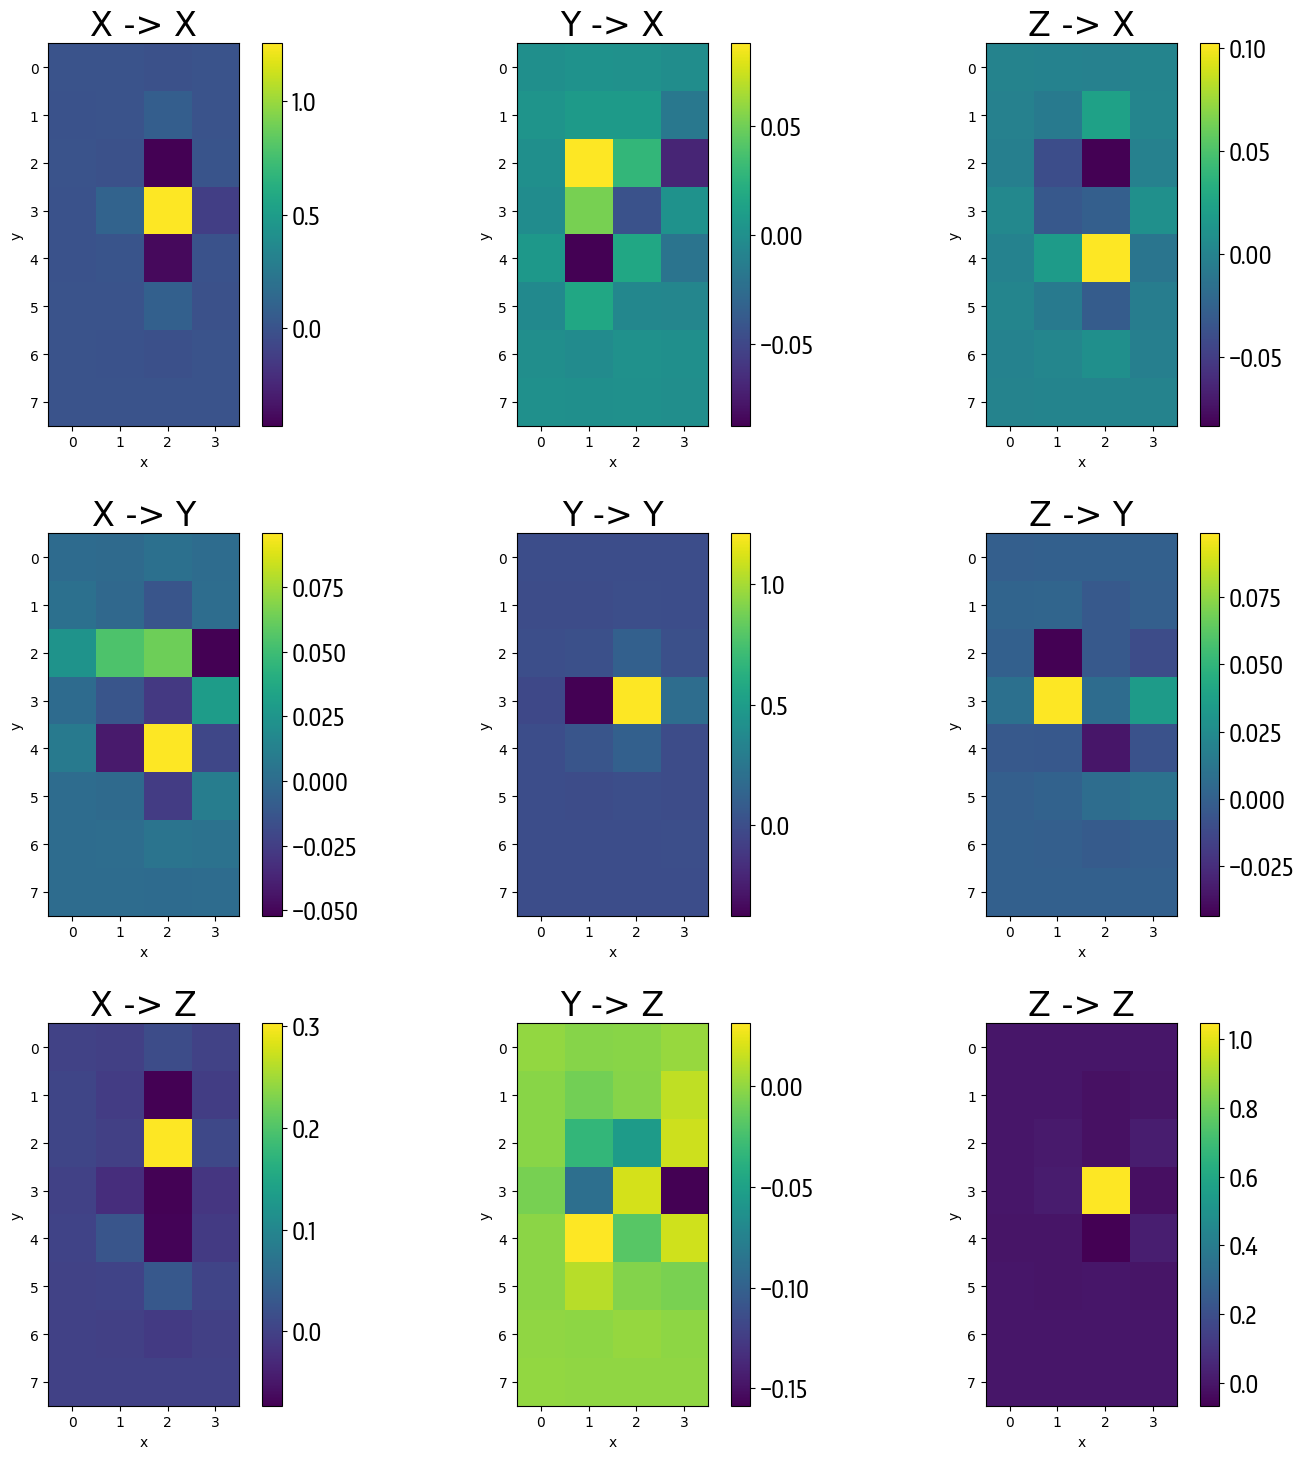

In [12]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 20

components = [': X', ': Y', ': Z']

# M is (96, 96) matrix
# F_x1, F_y1, F_z1, F_x2, F_y2, F_z2, ..., F_x32, F_y32, F_z32


TAXEL_ID = 14
data_slice = M[TAXEL_ID * 3 : (TAXEL_ID + 1) * 3, :]
data_slice_G_x = data_slice[0, :]
data_slice_G_y = data_slice[1, :]
data_slice_G_z = data_slice[2, :]

for i, G_comp in enumerate(['X', 'Y', 'Z']):
    for j, F_comp in enumerate(['X', 'Y', 'Z']):
        ax = axes[i, j]
        data_slice_new = data_slice[i, j::3].reshape((8, 4))
        cax = ax.imshow(data_slice_new, cmap='viridis', interpolation='none')

        fig.colorbar(cax, ax=ax)  # Add colorbar to the current subplot
        ax.set_title(f'{F_comp} -> {G_comp}')  # Set the title for the current subplot

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(8))  
        
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("plots/c4_stageII_matrices.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
print(bias.shape)

(96,)


In [25]:
class StageIIModel:
  def __init__(self, stage_I_model, M, bias) -> None:
    
    self.stage_I_model = stage_I_model
    self.M = M
    self.bias = bias
    
  def reshape_stage_2_input_vector(self, input_forces):
  
    nr_taxels, max_index, nr_features_per_taxel = input_forces.shape
    
    X = np.zeros((max_index, nr_taxels * nr_features_per_taxel))
    
    for k in range(nr_taxels):
      X[:, k * nr_features_per_taxel : (k+1) * nr_features_per_taxel] = input_forces[k]
      
    return X
    
  def predict(self, df):
    
    orig_forces = self.stage_I_model.predict(df)
    F = self.reshape_stage_2_input_vector(orig_forces).T - self.bias[:, None]
    G = self.M @ F
    
    return G.T, F.T
  
  def predict_single(self, X):
    
    orig_forces = self.stage_I_model.predict_single(X)
    F = self.reshape_stage_2_input_vector(orig_forces).T - self.bias[:, None]
    G = self.M @ F
    
    return G.T, F.T
  
stage_II_model = StageIIModel(stage_I_model, M, bias)

In [15]:
taxels_data[0][['F_x', 'F_y', 'F_z']].shape

(74133, 3)

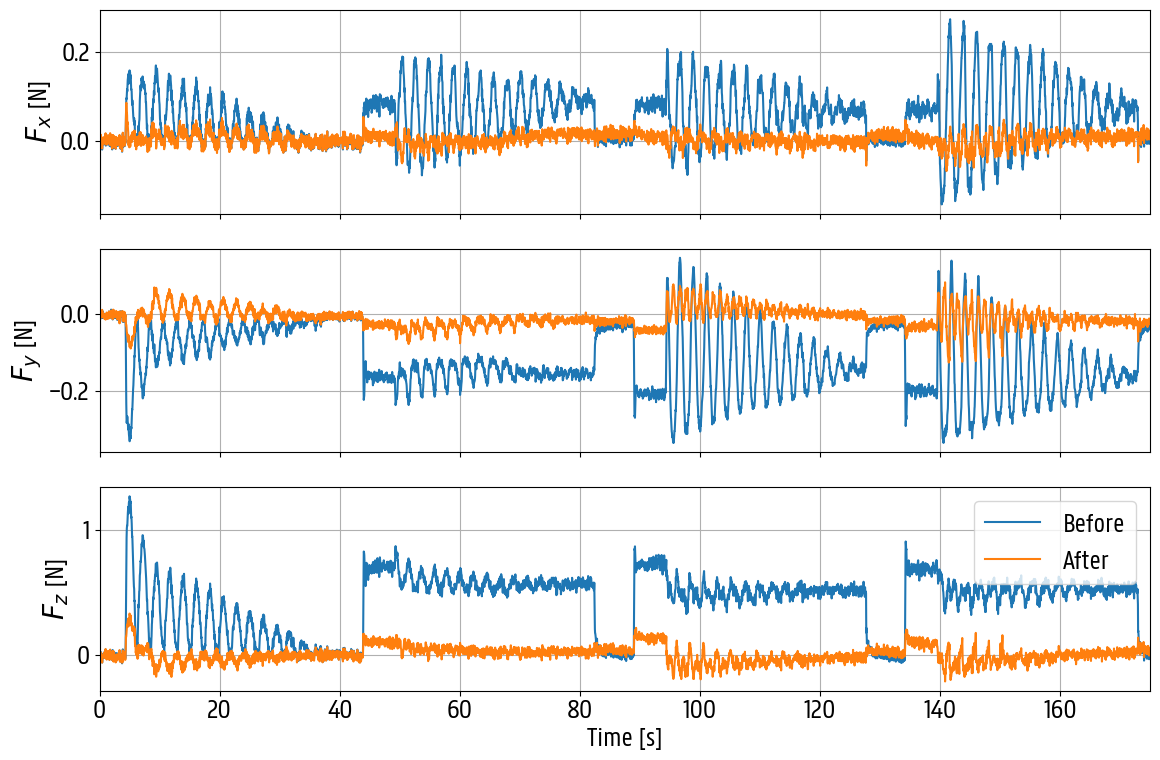

In [16]:
G, F_comp = stage_II_model.predict(taxels_data[1][1000:])

for i in [0]:
  
  fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
  t = np.linspace(0, 350/2, len(G))
  
  X, Y, Z = F_comp.T[i * 3: (i+1) * 3]
  
  axs[0].plot(t, X, label='Before')  
  axs[1].plot(t, Y, label='Before')  
  axs[2].plot(t, Z, label='Before')   

  X, Y, Z = G.T[i * 3: (i+1) * 3]
  
  axs[0].plot(t, X, label='After')  
  axs[0].set_ylabel('$F_x$ [N]') 
  axs[0].grid()
  
  axs[1].plot(t, Y, label='After')  
  axs[1].set_ylabel('$F_y$ [N]') 
  axs[1].grid()
  
  axs[2].plot(t, Z, label='After')    
  axs[2].set_ylabel('$F_z$ [N]') 
  axs[2].grid()

  plt.xlim([0, 350/2])
  plt.xlabel('Time [s]')
  
  plt.legend()
 
  plt.tight_layout()
  plt.savefig("plots/c4_s2_lin_ex.pdf", format="pdf", bbox_inches="tight")
  plt.show()

In [17]:
RMSEs_orig = []
RMSEs_after = []

RMSEs_origx = []
RMSEs_origy = []
RMSEs_origz = []

RMSEs_afterx = []
RMSEs_aftery = []
RMSEs_afterz = []

# Now calculate the NMSE for every dataset
for i in range(ARRAY_SIZE):
  
  print(f"Calculating NMSE for taxel {i}...")
  
  # Calculate the NMSE for every dataset
  Gall, F_compall = stage_II_model.predict(taxels_data[i][1000:75000])

  G = np.zeros_like(Gall)
  F_comp = np.zeros_like(F_compall)
  
  # Only calculate the RMSE on the neighbours of course  
  neighbours = neighbour_elements[i]
  for neighbour in neighbours:
    G[:, neighbour * 3 : (neighbour + 1) * 3] = Gall[:, neighbour * 3 : (neighbour + 1) * 3]
    F_comp[:, neighbour * 3 : (neighbour + 1) * 3] = F_compall[:, neighbour * 3 : (neighbour + 1) * 3]

  # Calculate Gref  
  Gref = np.zeros_like(G)
  Gref[:, i * 3 : (i + 1) * 3] = G[:, i * 3 : (i + 1) * 3]
  
  RMSE_orig = reg.calculate_RMSE(Gref, F_comp)
  RMSE_after = reg.calculate_RMSE(Gref, G)

  RMSEs_origx.append(reg.calculate_RMSE(Gref[:, ::3], F_comp[:, ::3]))
  RMSEs_origy.append(reg.calculate_RMSE(Gref[:, 1::3], F_comp[:, 1::3]))
  RMSEs_origz.append(reg.calculate_RMSE(Gref[:, 2::3], F_comp[:, 2::3]))
  
  RMSEs_afterx.append(reg.calculate_RMSE(Gref[:, ::3], G[:, ::3]))
  RMSEs_aftery.append(reg.calculate_RMSE(Gref[:, 1::3], G[:, 1::3]))
  RMSEs_afterz.append(reg.calculate_RMSE(Gref[:, 2::3], G[:, 2::3]))
  
  RMSEs_orig.append(RMSE_orig)
  RMSEs_after.append(RMSE_after)
  
  print(f"RMSE for taxel {i} : {RMSE_orig} -> {RMSE_after}")



Calculating NMSE for taxel 0...
RMSE for taxel 0 : 0.020047925752151016 -> 0.008626601935775136
Calculating NMSE for taxel 1...
RMSE for taxel 1 : 0.030444994677538365 -> 0.013410915102026882
Calculating NMSE for taxel 2...
RMSE for taxel 2 : 0.05428747976327816 -> 0.01479310632687184
Calculating NMSE for taxel 3...
RMSE for taxel 3 : 0.010949039217988182 -> 0.004002353247122086
Calculating NMSE for taxel 4...
RMSE for taxel 4 : 0.048050875604373135 -> 0.03012540498614168
Calculating NMSE for taxel 5...
RMSE for taxel 5 : 0.04322807473914366 -> 0.015244187944174911
Calculating NMSE for taxel 6...
RMSE for taxel 6 : 0.05254136771008492 -> 0.014461577755210763
Calculating NMSE for taxel 7...
RMSE for taxel 7 : 0.027489665182789304 -> 0.009838386871029496
Calculating NMSE for taxel 8...
RMSE for taxel 8 : 0.06209587520992751 -> 0.016375913202176063
Calculating NMSE for taxel 9...
RMSE for taxel 9 : 0.06738102338870246 -> 0.015409927570259758
Calculating NMSE for taxel 10...
RMSE for taxel

In [18]:
print(f"{np.mean(RMSEs_orig):.6f}")
print(f"{np.mean(RMSEs_after):.6f}")
print("---")
print(f"{np.mean(RMSEs_origx):.5f}")
print(f"{np.mean(RMSEs_origy):.5f}")
print(f"{np.mean(RMSEs_origz):.5f}")
print("---")
print(f"{np.mean(RMSEs_afterx):.5f}")
print(f"{np.mean(RMSEs_aftery):.5f}")
print(f"{np.mean(RMSEs_afterz):.5f}")
print("===")
print(f"{np.std(RMSEs_orig):.5f}")
print(f"{np.std(RMSEs_after):.5f}")
print("---")
print(f"{np.std(RMSEs_origx):.5f}")
print(f"{np.std(RMSEs_origy):.5f}")
print(f"{np.std(RMSEs_origz):.5f}")
print("---")
print(f"{np.std(RMSEs_afterx):.5f}")
print(f"{np.std(RMSEs_aftery):.5f}")
print(f"{np.std(RMSEs_afterz):.5f}")


0.040980
0.013307
---
0.03855
0.03257
0.05182
---
0.01081
0.00976
0.01936
===
0.01421
0.00536
---
0.01744
0.01249
0.01999
---
0.00399
0.00458
0.01014


In [19]:
# Construct the latex table body
table_body = ""

for i in range(ARRAY_SIZE):
    table_body += f"Taxel {i} "

    table_body += f"& \multicolumn{{1}}{{l|}}{{{RMSEs_origx[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_origy[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_origz[i]:.5f}}} & {{{RMSEs_orig[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_afterx[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_aftery[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_afterz[i]:.5f}}} & {{{RMSEs_after[i]:.5f}}}"
    
    table_body += "\\\\ \hline \n"

print(table_body)

Taxel 0 & \multicolumn{1}{l|}{0.02006} & \multicolumn{1}{l|}{0.01338} & \multicolumn{1}{l|}{0.02670} & {0.02005} & \multicolumn{1}{l|}{0.00714} & \multicolumn{1}{l|}{0.00413} & \multicolumn{1}{l|}{0.01461} & {0.00863}\\ \hline 
Taxel 1 & \multicolumn{1}{l|}{0.03321} & \multicolumn{1}{l|}{0.02253} & \multicolumn{1}{l|}{0.03560} & {0.03044} & \multicolumn{1}{l|}{0.01753} & \multicolumn{1}{l|}{0.01284} & \multicolumn{1}{l|}{0.00987} & {0.01341}\\ \hline 
Taxel 2 & \multicolumn{1}{l|}{0.04591} & \multicolumn{1}{l|}{0.02070} & \multicolumn{1}{l|}{0.09625} & {0.05429} & \multicolumn{1}{l|}{0.01157} & \multicolumn{1}{l|}{0.00820} & \multicolumn{1}{l|}{0.02461} & {0.01479}\\ \hline 
Taxel 3 & \multicolumn{1}{l|}{0.00816} & \multicolumn{1}{l|}{0.01032} & \multicolumn{1}{l|}{0.01436} & {0.01095} & \multicolumn{1}{l|}{0.00240} & \multicolumn{1}{l|}{0.00292} & \multicolumn{1}{l|}{0.00669} & {0.00400}\\ \hline 
Taxel 4 & \multicolumn{1}{l|}{0.03180} & \multicolumn{1}{l|}{0.03883} & \multicolumn{1}{

In [26]:
# Save the model
reg.save_taxel_models(stage_II_model, "4x8", "stageII")

In [139]:
with open(os.path.join(save_path, f"stageII"), 'rb') as f:
    stage_II_model = dill.load(f)     